In [1]:
import os
import requests, tarfile
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

/Users/box/Study/CISC7014/HW2


In [2]:
CIFAR_DIR = os.path.join(CURRENT_DIR, 'data','cifar')
print(CIFAR_DIR)
def download_CIFAR(path=CIFAR_DIR, url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', redownload=False):
    if os.path.exists(path) and redownload is False:
        print('Dataset already exists')
        return
    print('Downloading...')
    r = requests.get(url, stream=True)
    # show download progress
    total_length = r.headers.get('content-length')
    with open('cifar-10-python.tar.gz', 'wb') as f:
        if total_length is None: # no content length header
            f.write(r.content)
        else:
            dl = 0
            total_length = int(total_length)
            for chunk in r.iter_content(chunk_size=1024):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                print('\r[{}{}]'.format('=' * done, ' ' * (50-done)), end='')
    print('Extracting...')
    with tarfile.open('cifar-10-python.tar.gz') as f:
        f.extractall(path)
    print('Done!')

download_CIFAR()

/Users/box/Study/CISC7014/HW2/data/cifar
Dataset already exists


In [3]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

# load meta data
meta = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'batches.meta'))
print(meta['label_names'])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# load all train data and combine all data them into one
import numpy as np
cifar_train_files = ['data_batch_{}'.format(i) for i in range(1,6)]
print(cifar_train_files)
cifar_train_data = [unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', f)) for f in cifar_train_files]

cifar_train_imgs = np.vstack([d['data'] for d in cifar_train_data])
cifar_train_labels = np.hstack([d['labels'] for d in cifar_train_data])

print(cifar_train_imgs.shape, cifar_train_labels.shape)

['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
(50000, 3072) (50000,)


In [9]:
# load all test data
cifar_test_data = unpickle(os.path.join(CIFAR_DIR, 'cifar-10-batches-py', 'test_batch'))
cifar_test_imgs = cifar_test_data['data']
cifar_test_labels = np.array(cifar_test_data['labels'])

In [10]:
# reshape the images
cifar_train_imgs = cifar_train_imgs.reshape((50000, 3, 32, 32))
cifar_train_imgs = np.rollaxis(cifar_train_imgs, 1, 4)
cifar_train_labels = cifar_train_labels.reshape((50000, 1))

cifar_test_imgs = cifar_test_imgs.reshape((10000, 3, 32, 32))
cifar_test_imgs = np.rollaxis(cifar_test_imgs, 1, 4)
cifar_test_labels = cifar_test_labels.reshape((10000, 1))


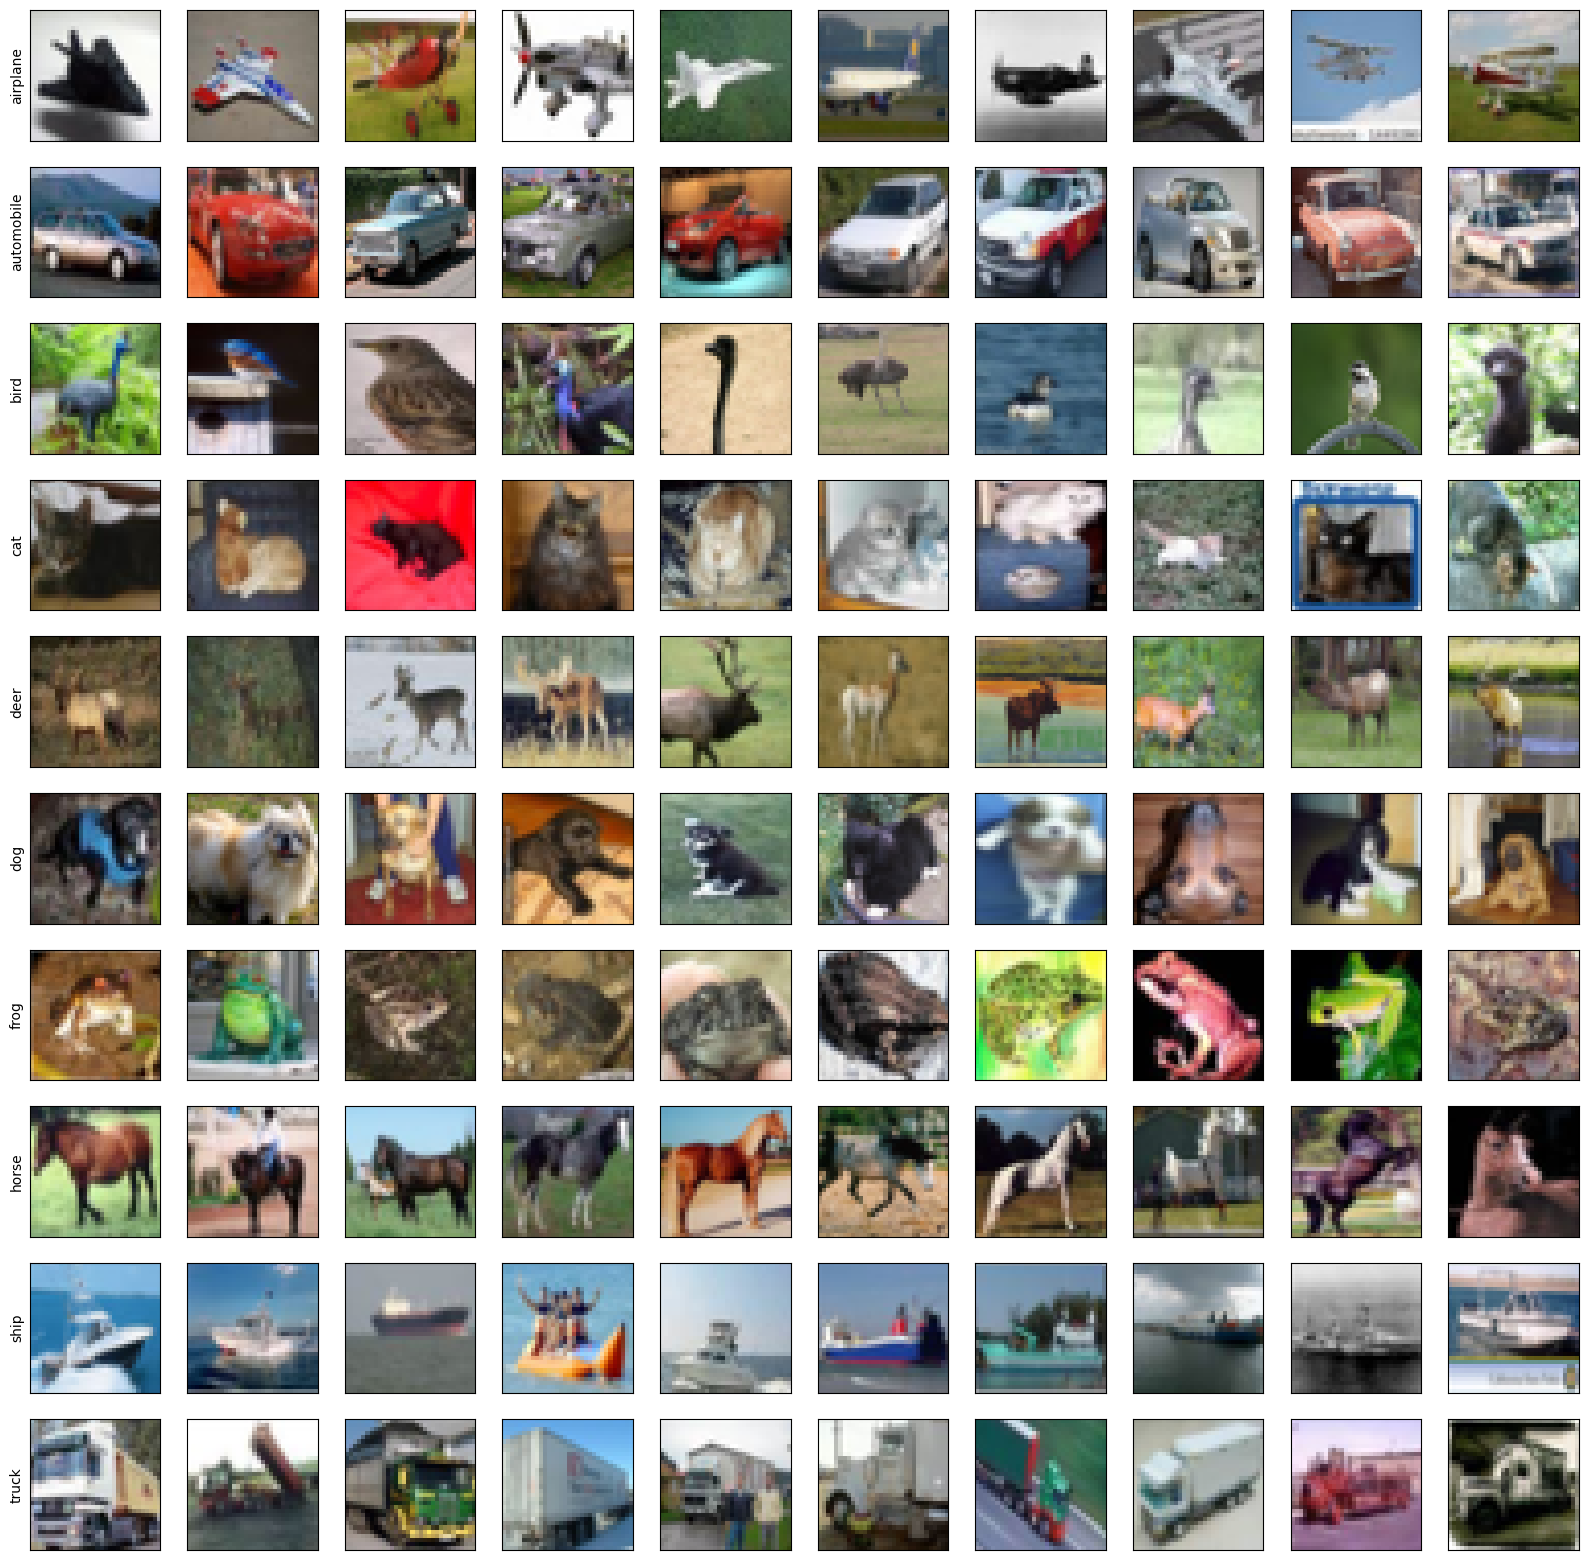

In [11]:
# show 5 images of each label and their names
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    idx = np.where(cifar_train_labels == i)[0]
    for j in range(10):
        axes[i][j].imshow(cifar_train_imgs[idx[j]])
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
    axes[i][0].set_ylabel(meta['label_names'][i])

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


fasgion_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

fasgion_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

5.3%

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




21.5%

100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



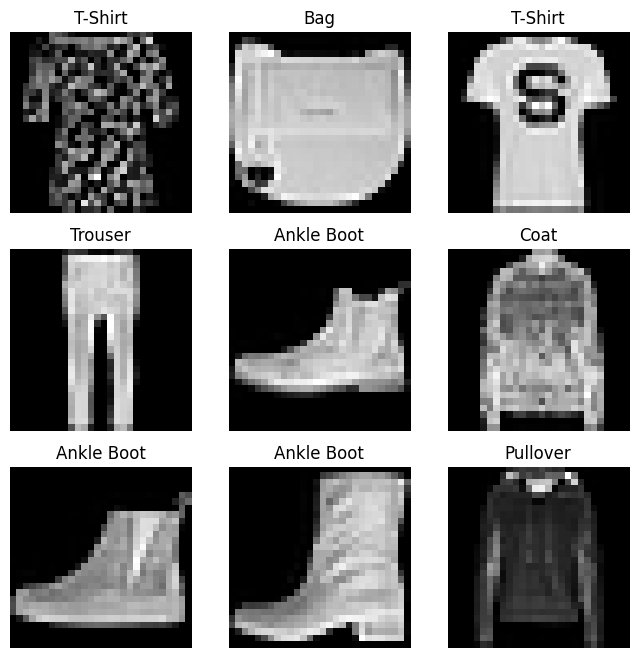

In [14]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fasgion_training_data), size=(1,)).item()
    img, label = fasgion_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()